## Overfitting MNIST with MLP

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
seed = 7
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(seed)

# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector; view takes dimension of the tensor to be output
])

trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

In [ ]:
def train_model(model):
  # define the loss function and the optimiser
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.Adam(model.parameters())

  train_loss = torch.empty(10).to(device)
  train_acc = torch.empty(10).to(device)

  test_loss = torch.empty(10).to(device)
  test_acc = torch.empty(10).to(device)

  # the epoch loop
  for epoch in range(10):
      running_loss = 0.0
      acc = 0.0
      for data in trainloader:
          model.train()
          # get the inputs
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimiser.zero_grad()

          # forward + loss + backward + optimise (update weights)
          outputs = model(inputs)
          loss = loss_function(outputs, labels)
          loss.backward()
          optimiser.step()

          # keep track of the loss this epoch
          running_loss += loss.item()
          
          # eval accuracy
          model.eval()
          with torch.no_grad():
              outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          acc += (preds == labels).sum()
          

      acc /= len(trainloader.dataset)
      running_loss /= len(trainloader)

      train_loss[epoch] = running_loss
      train_acc[epoch] = acc

      
      # test evaluation
      model.eval()
      with torch.no_grad():
          running_loss = 0.0
          acc = 0.0
          for data in testloader:
              inputs, labels = data
              inputs = inputs.to(device)
              labels = labels.to(device)

              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
          
              loss = F.nll_loss(torch.log(outputs), labels)

              acc += (preds == labels).sum()
              running_loss += loss.item()
            
          acc /= len(testloader.dataset)
          running_loss /= len(testloader)

          test_loss[epoch] = running_loss
          test_acc[epoch] = acc

      print(f"Epoch {epoch}, train loss {train_loss[epoch]}, train accuracy {train_acc[epoch]}, test loss {test_loss[epoch]}, test accuracy {test_acc[epoch]}")


  print('**** Finished Training ****')

  return train_loss.cpu().numpy(), train_acc.cpu().numpy(), test_loss.cpu().numpy(), test_acc.cpu().numpy()

In [ ]:
model_list = []
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

hidden_size_list = [500, 1000, 5000, 10000, 20000, 40000]

for hidden_size in hidden_size_list:
    print(f"hidden_size = {hidden_size}")
    model = BaselineModel(784, hidden_size, 10).to(device)
    train_loss, train_acc, test_loss, test_acc = train_model(model)

    model_list.append(model)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print("\n")

hidden_size = 500
Epoch 0, train loss 0.31680166721343994, train accuracy 0.9204500317573547, test loss 0.1623217612504959, test accuracy 0.952299952507019
Epoch 1, train loss 0.12714730203151703, train accuracy 0.9672666788101196, test loss 0.10518555343151093, test accuracy 0.968999981880188
Epoch 2, train loss 0.08373573422431946, train accuracy 0.9785833358764648, test loss 0.07761766016483307, test accuracy 0.9763999581336975
Epoch 3, train loss 0.0610898993909359, train accuracy 0.9847666621208191, test loss 0.07539155334234238, test accuracy 0.97489994764328
Epoch 4, train loss 0.04565340653061867, train accuracy 0.989716649055481, test loss 0.06929250806570053, test accuracy 0.9781999588012695
Epoch 5, train loss 0.035032007843256, train accuracy 0.9925500154495239, test loss 0.06395147740840912, test accuracy 0.9797999858856201
Epoch 6, train loss 0.027022583410143852, train accuracy 0.9949166774749756, test loss 0.06555330753326416, test accuracy 0.9791999459266663
Epoch 7, t

Text(0.5, 0, 'Epochs')

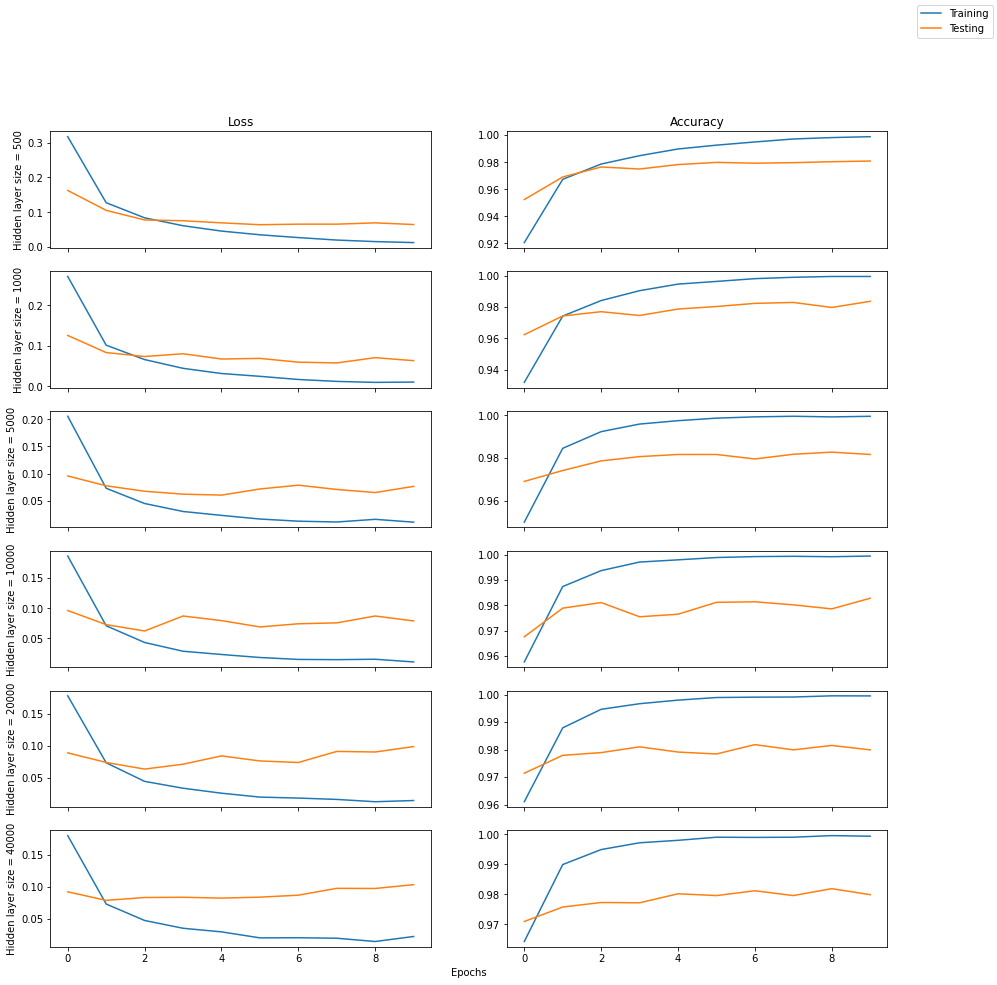

In [ ]:
fig, ax = plt.subplots(len(model_list), 2, figsize=(15, 15), sharex=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
for i in range(len(model_list)):
    ax[i, 0].plot(train_loss_list[i])
    ax[i, 0].plot(test_loss_list[i])
    ax[i, 1].plot(train_acc_list[i])
    ax[i, 1].plot(test_acc_list[i])
    ax[i, 0].set_ylabel(f"Hidden layer size = {hidden_size_list[i]}")
ax[0, 0].set_title("Loss")
ax[0, 1].set_title("Accuracy")
fig.legend(["Training", "Testing"])
plt.xlabel("Epochs")

In [ ]:
fig.savefig('loss_graph.jpg')

<Figure size 432x288 with 0 Axes>